<a href="https://colab.research.google.com/github/jhtwiz/hanghaeAI/blob/main/1%E1%84%8C%E1%85%AE%E1%84%8E%E1%85%A1_%E1%84%80%E1%85%B5%E1%84%87%E1%85%A9%E1%86%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [ ]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11659633.50it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 472262.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2777835.69it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4470905.60it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


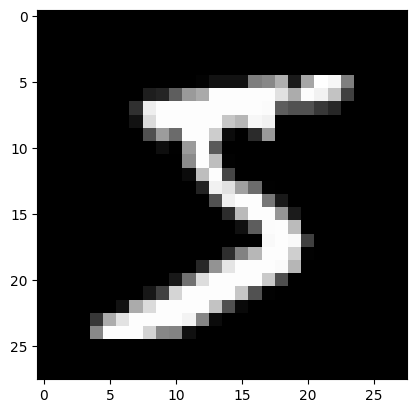

In [ ]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [ ]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


model = Model(28 * 28 * 1, 1024)

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [ ]:
from torch.optim import SGD

lr = 0.001

model = model.to('cuda')

optimizer = SGD(model.parameters(), lr=lr)

In [ ]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [ ]:
n_epochs = 100
train_accs = []
test_accs = []

for epoch in range(n_epochs):
  total_loss = 0.

  model.train()
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    CEL = torch.nn.CrossEntropyLoss()
    loss = CEL(preds, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  with torch.no_grad():
    model.eval()
    train_accs.append(accuracy(model, trainloader))
    test_accs.append(accuracy(model, testloader))

  print(f"Epoch {epoch:3d} | Loss: {total_loss}")

Epoch   0 | Loss: 539.4984204769135
Epoch   1 | Loss: 535.8103227615356
Epoch   2 | Loss: 532.0107560157776
Epoch   3 | Loss: 527.990475654602
Epoch   4 | Loss: 523.6347405910492
Epoch   5 | Loss: 518.7996454238892
Epoch   6 | Loss: 513.3515298366547
Epoch   7 | Loss: 507.13130736351013
Epoch   8 | Loss: 499.9875042438507
Epoch   9 | Loss: 491.7250566482544
Epoch  10 | Loss: 482.1554081439972
Epoch  11 | Loss: 471.0824419260025
Epoch  12 | Loss: 458.37228071689606
Epoch  13 | Loss: 443.89440977573395
Epoch  14 | Loss: 427.6169670820236
Epoch  15 | Loss: 409.69688856601715
Epoch  16 | Loss: 390.3476724624634
Epoch  17 | Loss: 370.0241402387619
Epoch  18 | Loss: 349.31751549243927
Epoch  19 | Loss: 328.8068996667862
Epoch  20 | Loss: 309.01637732982635
Epoch  21 | Loss: 290.4243264198303
Epoch  22 | Loss: 273.2560558319092
Epoch  23 | Loss: 257.5927919745445
Epoch  24 | Loss: 243.48889523744583
Epoch  25 | Loss: 230.78615748882294
Epoch  26 | Loss: 219.59047561883926
Epoch  27 | Loss: 20

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

In [ ]:
idx = 0

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 1.8066, -4.1246,  0.4329,  5.0027, -5.7139,  4.5489, -2.6498,  0.1183,
          1.2496, -0.6209]], device='cuda:0', grad_fn=<AddmmBackward0>)
5


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

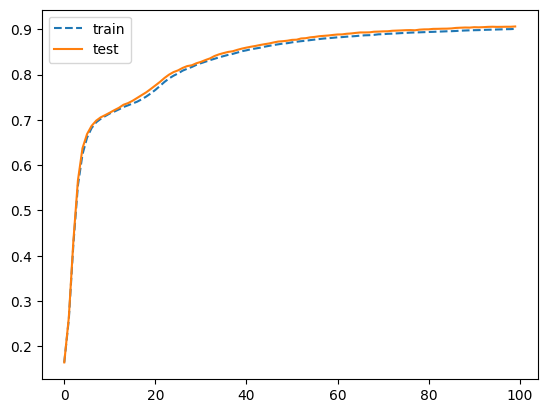

In [ ]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, '--', label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()


plot_acc(train_accs, test_accs)